In [ ]:
#Для работы с данными
import pandas as pd
import numpy as np

#Для визуализации
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as plex # библиотека для интерактивных графиков и анимаций №1 
import bokeh.plotting as bp # библиотека для интерактивных графиков и анимаций №2

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn import tree

#Для разделения данных на выборки
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

#Для оценивания прогноза (метрики точности) 
import sklearn.metrics 
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error

## Данные по инсоляции 

In [ ]:
df_2017 = pd.read_csv('/content/2017.csv', sep =',')
df_2018 = pd.read_csv('/content/2018.csv', sep =',')
df_2019 = pd.read_csv('/content/2019.csv', sep =',')

In [ ]:
df_sun = pd.DataFrame([])

In [ ]:
df_sun = df_2017.append(df_2018)

In [ ]:
df_sun = df_sun.append(df_2019)

In [ ]:
df_sun.drop(['Minute', 'Clearsky GHI', 'Clearsky DHI', 'Cloud Type', 'Dew Point', 'Clearsky DNI', 'Fill Flag', 'Relative Humidity', 'Ozone', 'Precipitable Water', 'Surface Albedo', 'Wind Direction', 'Wind Speed', 'Pressure', 'Temperature', 'DNI', 'DHI', 'Solar Zenith Angle'], axis = 1, inplace = True)

In [ ]:
df_sun = df_sun.query('Hour % 3 == 0')

In [ ]:
df_sun

Year  Month  Day  Hour  GHI
0     2017      1    1     0    0
3     2017      1    1     3    0
6     2017      1    1     6    0
9     2017      1    1     9   96
12    2017      1    1    12  373
...    ...    ...  ...   ...  ...
8745  2019     12   31     9   24
8748  2019     12   31    12   71
8751  2019     12   31    15   37
8754  2019     12   31    18    0
8757  2019     12   31    21    0

[8760 rows x 5 columns]

## Данные по погоде

In [ ]:
df = pd.read_excel('/content/New_meteo.xlsx')

In [ ]:
df.drop(['Po', 'P', 'Pa', 'DD', 'ff10', 'ff3', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'Td', 'tR', 'E', 'Tg', "E'", 'sss'], axis = 1, inplace = True)

In [ ]:
df_1 = df.iloc[::-1]

In [ ]:
df_1['Местное время в Алматы (аэропорт)'] = pd.to_datetime(df_1['Местное время в Алматы (аэропорт)'])
df_1['Year'] = df_1['Местное время в Алматы (аэропорт)'].dt.year
df_1['Month'] = df_1['Местное время в Алматы (аэропорт)'].dt.month
df_1['Day'] = df_1['Местное время в Алматы (аэропорт)'].dt.day
df_1['Hour'] = df_1['Местное время в Алматы (аэропорт)'].dt.hour
df_1['Minute'] = df_1['Местное время в Алматы (аэропорт)'].dt.minute
df_1.drop(['Местное время в Алматы (аэропорт)'], axis = 1, inplace = True)

In [ ]:
df_meteo = pd.DataFrame([])

In [ ]:
df_meteo[['Year', 'Month', 'Day', 'Hour', 'T', 'U', 'Ff', 'N', 'VV', 'RRR']] = df_1[['Year', 'Month', 'Day', 'Hour', 'T', 'U', 'Ff', 'N', 'VV', 'RRR']]

In [ ]:
df_meteo.rename(columns = {'T' : 'Temp', 'U' : 'Hum', 'Ff' : 'WindSpeed', 'N' : 'Cloud', 'VV' : 'Vis', 'RRR' : 'Precip'}, inplace = True) 

In [ ]:
df_meteo = df_meteo.reset_index().drop(['index'], axis = 1)

In [ ]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6414 entries, 0 to 6413
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       6414 non-null   int64  
 1   Month      6414 non-null   int64  
 2   Day        6414 non-null   int64  
 3   Hour       6414 non-null   int64  
 4   Temp       6410 non-null   float64
 5   Hum        6405 non-null   float64
 6   WindSpeed  6177 non-null   float64
 7   Cloud      6177 non-null   object 
 8   Vis        4354 non-null   object 
 9   Precip     619 non-null    object 
dtypes: float64(3), int64(4), object(3)
memory usage: 501.2+ KB


In [ ]:
df_meteo.Precip.isna().sum()

5795

In [ ]:
df_meteo.drop(['Precip'], axis = 1, inplace = True)

In [ ]:
dicts_1 = {'менее 0.1':0.05, 'менее 0.05' : 0.01}
for i in range(len(df_meteo['Vis'])):
  try:
    df_meteo.iloc[i,8] = dicts_1[df_meteo.iloc[i,8]]
  except:
    pass

In [ ]:
df_meteo.dropna(subset = ['Cloud', 'WindSpeed', 'Hum', 'Temp'], inplace = True)

In [ ]:
dicts = {'100%.': 100, '90  или более, но не 100%':90,
 '20–30%.':25, '40%.':40, '70 – 80%.' : 75, '50%.':50, '60%.' : 60,
 'Облаков нет.': 0, 'Небо не видно из-за тумана и/или других метеорологических явлений.': 15, 
 '10%  или менее, но не 0': 10}

In [ ]:
for i in range(len(df_meteo['Cloud'])):
  df_meteo.iloc[i,7] = dicts[df_meteo.iloc[i,7]]

In [ ]:
df_meteo['Cloud'] = df_meteo['Cloud'].astype('int')

In [ ]:
df_meteo.Vis.isna().sum()

2044

In [ ]:
df_meteo['Vis'] = df_meteo.Vis.fillna(np.median(df_meteo.Vis))

## Сборка данных

In [ ]:
data = df_meteo.merge(df_sun, how = 'left')

In [ ]:
data.isna().sum()

Year         0
Month        0
Day          0
Hour         0
Temp         0
Hum          0
WindSpeed    0
Cloud        0
Vis          0
GHI          0
dtype: int64

In [ ]:
data.dtypes

Year           int64
Month          int64
Day            int64
Hour           int64
Temp         float64
Hum          float64
WindSpeed    float64
Cloud          int64
Vis          float64
GHI            int64
dtype: object

In [ ]:
data

Year  Month  Day  Hour  Temp   Hum  WindSpeed  Cloud  Vis  GHI
0     2017      1    1     0  -3.1  84.0        1.0    100  1.6    0
1     2017      1    1     3  -2.8  90.0        1.0    100  1.0    0
2     2017      1    1     6  -2.9  92.0        3.0    100  1.3    0
3     2017      1    1     9  -2.4  89.0        1.0     90  1.1   96
4     2017      1    1    12   1.4  72.0        0.0     50  2.2  373
...    ...    ...  ...   ...   ...   ...        ...    ...  ...  ...
6166  2019     12   31     9  -2.3  98.0        2.0    100  3.8   24
6167  2019     12   31    12  -0.3  92.0        1.0    100  4.0   71
6168  2019     12   31    15   0.0  89.0        2.0    100  4.0   37
6169  2019     12   31    18  -0.3  91.0        3.0    100  4.0    0
6170  2019     12   31    21  -1.3  92.0        1.0    100  3.5    0

[6171 rows x 10 columns]

## Подготовка

Text(0, 0.5, 'GHI, Wh/m^2')

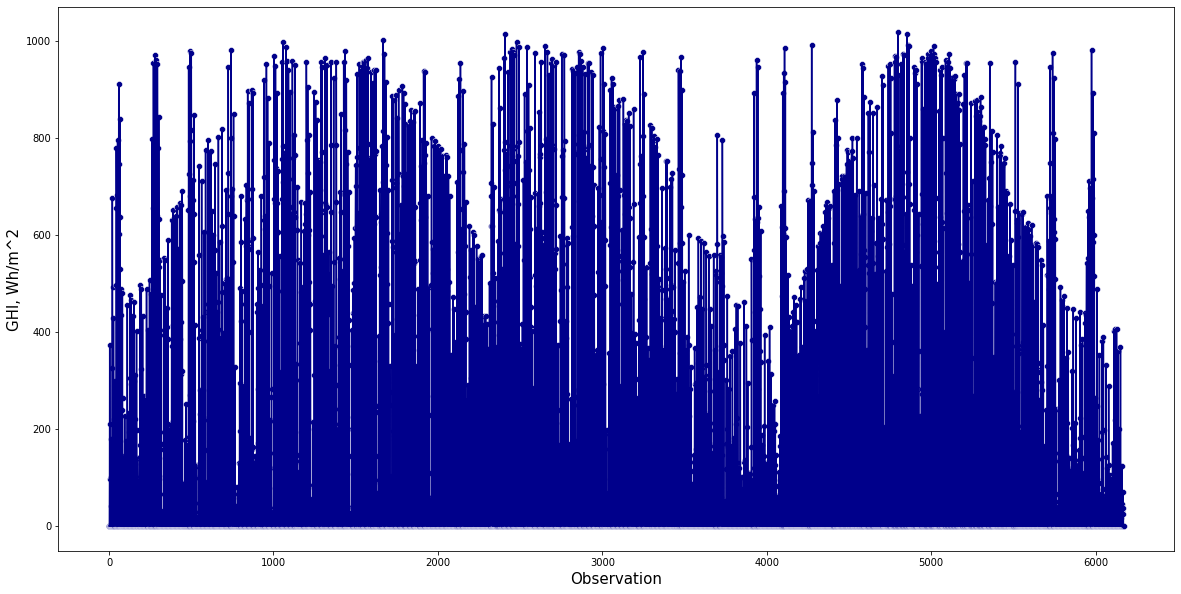

In [ ]:
plt.figure(figsize=(20,10))
sn.scatterplot(y=data['GHI'], x=data.index, color='darkblue')
sn.lineplot(y=data['GHI'], x=data.index, color='darkblue')
plt.xlabel('Observation', fontsize=15)
plt.ylabel('GHI, Wh/m^2', fontsize=15)

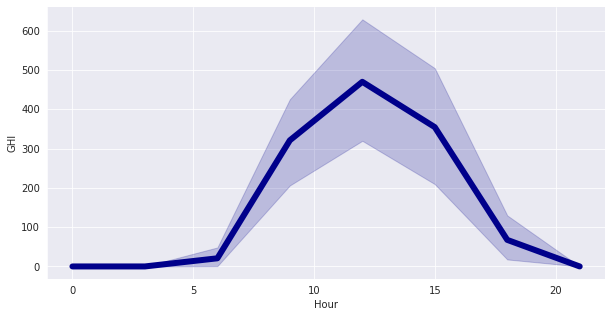

In [ ]:
figure = plt.figure(figsize=(10,5)) 
sn.set_style('dark') 
sn.lineplot(y=data.GHI[:100], x=data.Hour[:100], linewidth=6, color='darkblue')
sn.despine(figure)
plt.grid() 

In [ ]:
data2=data.drop(data[data['GHI']== 0].index)

Text(0, 0.5, 'GHI, Wh/m^2')

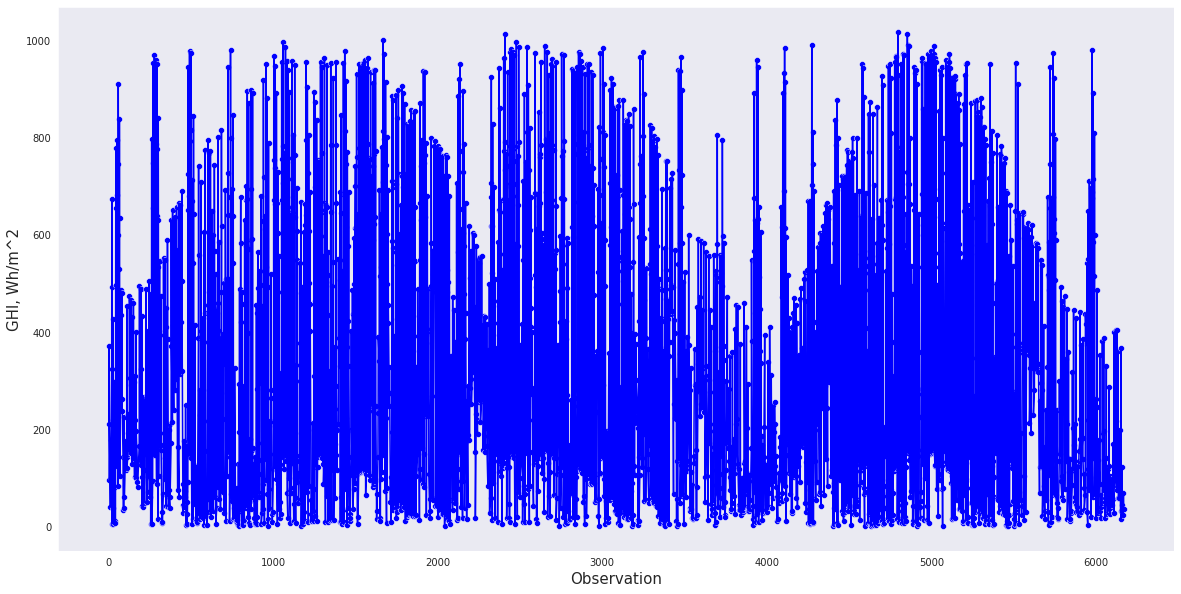

In [ ]:
plt.figure(figsize=(20,10))
sn.scatterplot(y=data2['GHI'], x=data2.index, color='b')
sn.lineplot(y=data2['GHI'], x=data2.index, color='b')
plt.xlabel('Observation', fontsize=15)
plt.ylabel('GHI, Wh/m^2', fontsize=15)

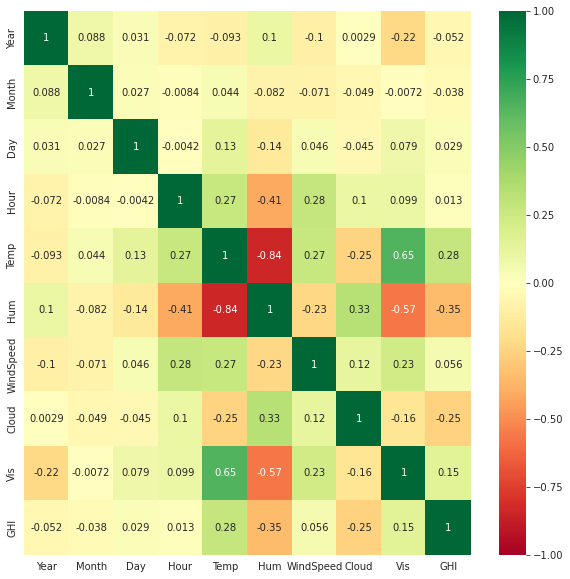

In [ ]:
plt.figure(figsize=(10, 10))
sn.heatmap(data2.corr(), cmap='RdYlGn', vmax=1, vmin=-1, annot=True)

In [ ]:
X = data2.drop(['GHI'], axis=1)
y = data2['GHI']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2436, 9) (812, 9) (2436,) (812,)


In [ ]:
y_test.to_excel('/y_test.xlsx')
X_test.to_excel('/X_test.xlsx')

## Модель линейной регрессии

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
scoring  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores = cross_validate(lin_reg, X_train, y_train, scoring = scoring, cv=ShuffleSplit(n_splits=5))
y_pred = lin_reg.predict(X_test)
print('Cross-Validation errors')
DF_reg = pd.DataFrame(scores)
display(DF_reg)
print('Test errors')
print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred))

Cross-Validation errors


fit_time  score_time   test_R2     test_-MSE   test_-MAE    test_Max
0  0.016272    0.012229  0.177420 -65970.487551 -217.044236 -788.712317
1  0.017919    0.023447  0.198934 -63432.908147 -213.173967 -670.882808
2  0.015325    0.011526  0.140228 -75718.831068 -234.187085 -691.193920
3  0.017789    0.011752  0.173642 -70479.802122 -222.041152 -827.869925
4  0.015316    0.006283  0.118418 -67850.701830 -220.126366 -717.299617

Test errors
Mean squared error on test_set: 71540.4417
R2  on test_set: 0.1324


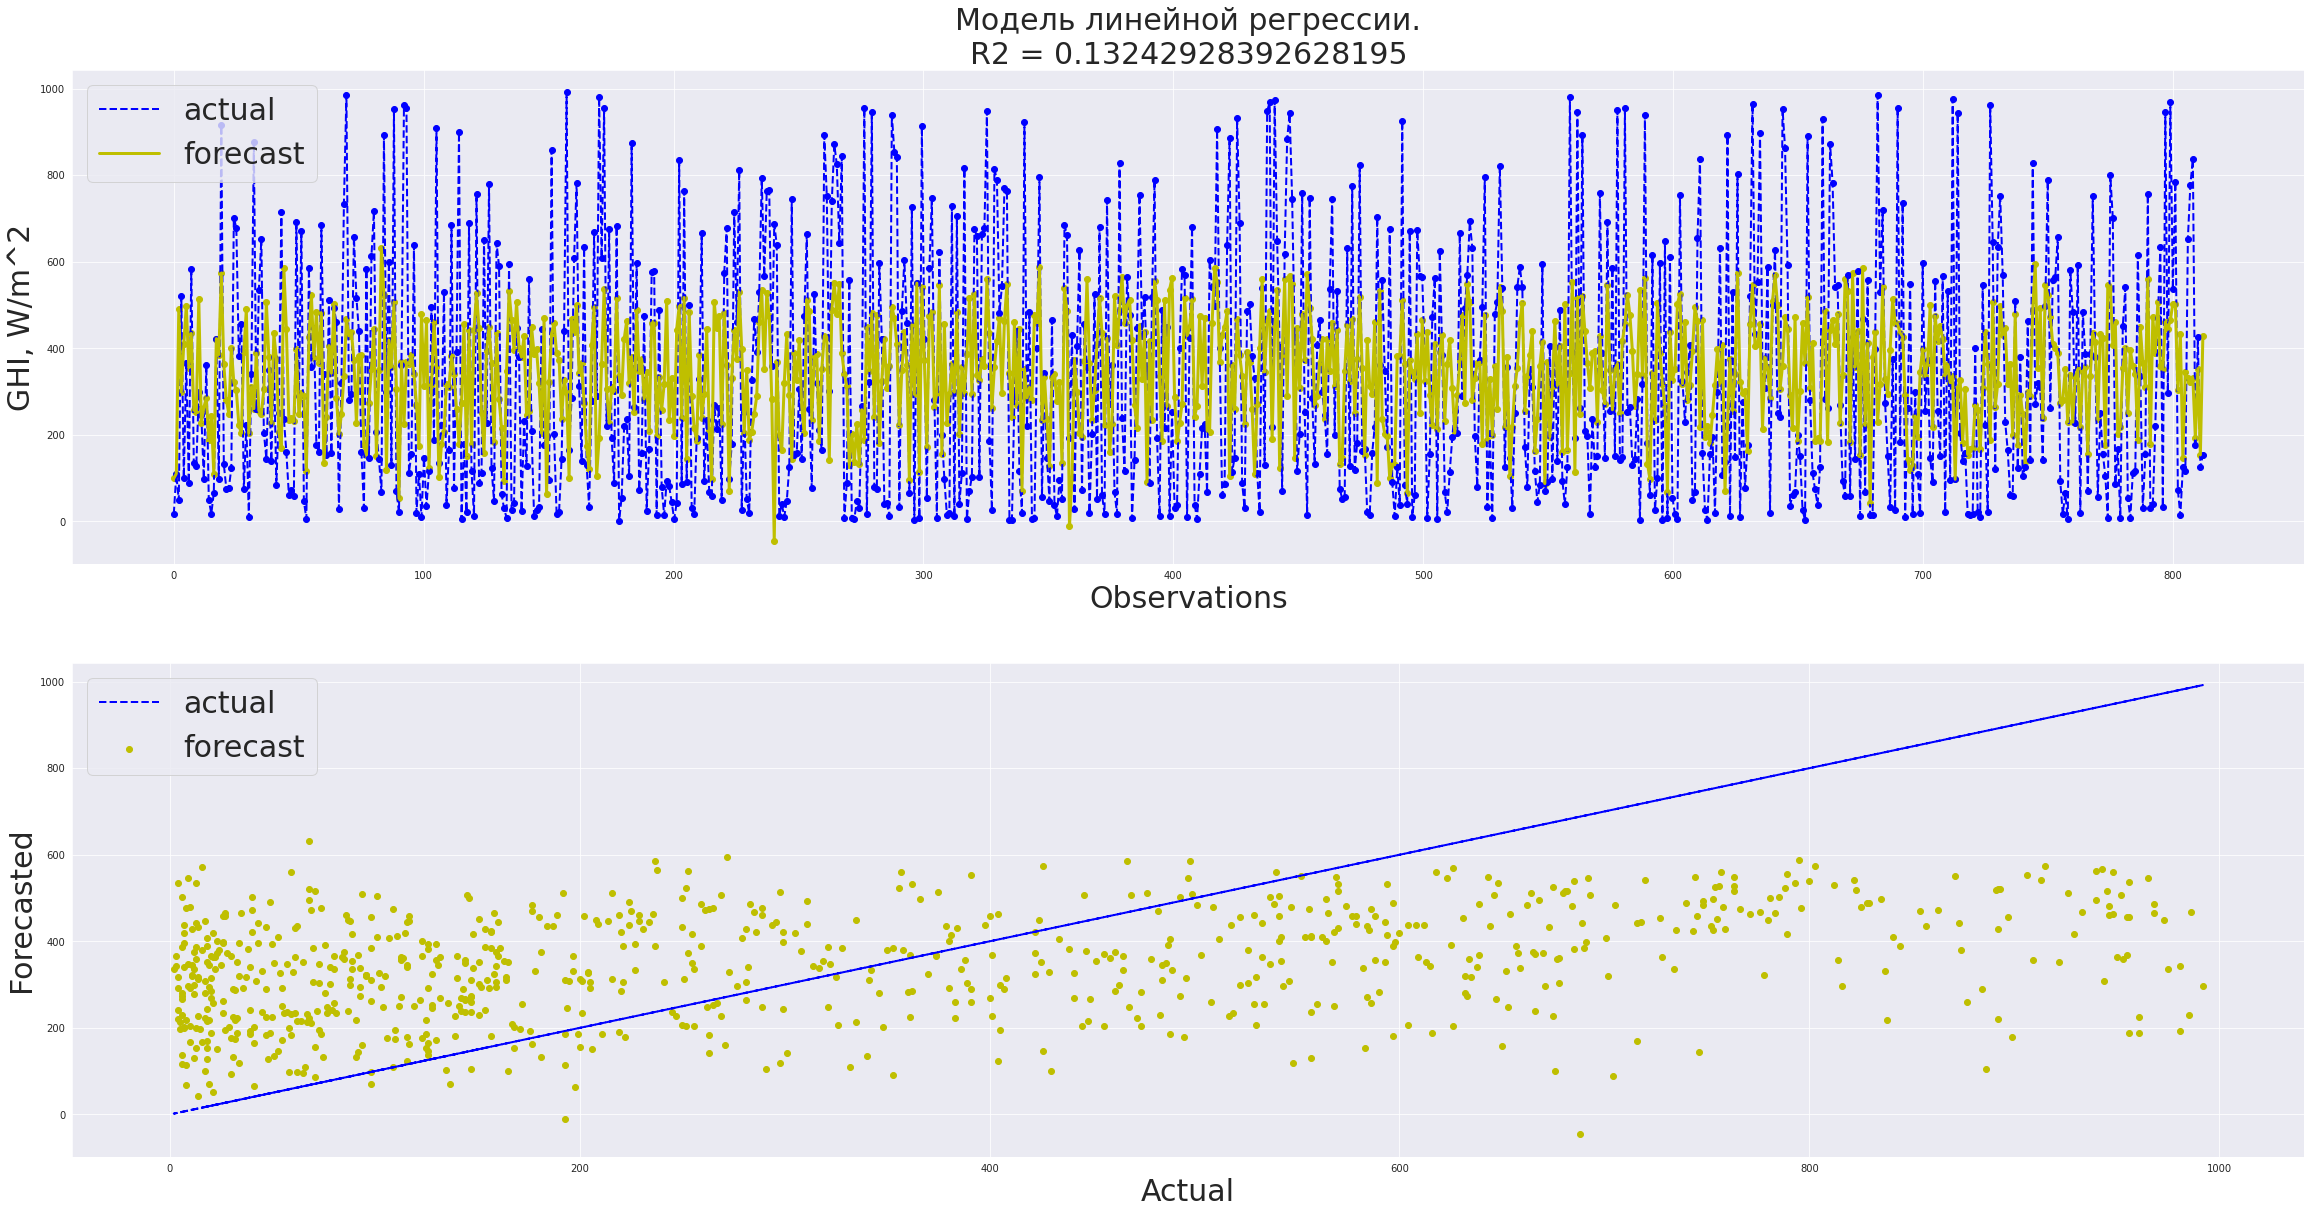

In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0])
plt.figure(figsize=(40,20))
plt.subplot(2,1,1)
plt.title(f'Модель линейной регрессии.\nR2 = {r2_score(y_test,y_pred)}', fontsize=30)
plt.scatter(x, y_pred, c='y')
plt.scatter(x, y_test, c='b')
plt.plot(x, y_test, '--b', linewidth=2, label='actual')
plt.plot(x, y_pred, '-y', linewidth=3, label='forecast')
plt.legend(fontsize=30)
plt.xlabel('Observations', fontsize=30)
plt.ylabel('GHI, W/m^2', fontsize=30)
plt.grid()
plt.subplot(2,1,2)
plt.plot(y_test, y_test, '--b', linewidth=2, label='actual')
plt.scatter(y_test, y_pred, label='forecast', c='y')
plt.legend(fontsize=30)
plt.xlabel('Actual', fontsize=30)
plt.ylabel('Forecasted', fontsize=30)
plt.grid()

## Модель полиномиальной регрессии

In [ ]:
from sklearn.preprocessing import PolynomialFeatures as poly
from sklearn.pipeline import Pipeline

In [ ]:
PF = poly(degree=2, include_bias=True, interaction_only=False)
#Rid = Ridge(alpha=0.1)
LR = LinearRegression()
pipe = Pipeline([('polynomial_features', PF), ('lr', LR)])
pipe.fit(X_train, y_train)
scoring_pipe  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores_pipe = cross_validate(pipe, X_train, y_train, scoring = scoring_pipe, cv=ShuffleSplit(n_splits=5))
y_pred_pipe = pipe.predict(X_test)
print('Cross-Validation error')
DF_reg_pipe = pd.DataFrame(scores_pipe)
display(DF_reg_pipe)

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_pipe))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_pipe))

Cross-Validation error


fit_time  score_time   test_R2     test_-MSE   test_-MAE    test_Max
0  0.045806    0.008626  0.747961 -22883.865303 -111.969333 -518.841039
1  0.047609    0.006826  0.756391 -20308.162897 -104.673929 -579.132533
2  0.037816    0.007702  0.763671 -22536.734733 -112.490468 -583.715046
3  0.085592    0.012917  0.792303 -17504.140020  -96.597291 -530.277343
4  0.042021    0.013985  0.716915 -21166.248732 -107.843539 -587.235871

Mean squared error on test_set: 21054.0606
R2  on test_set: 0.7447


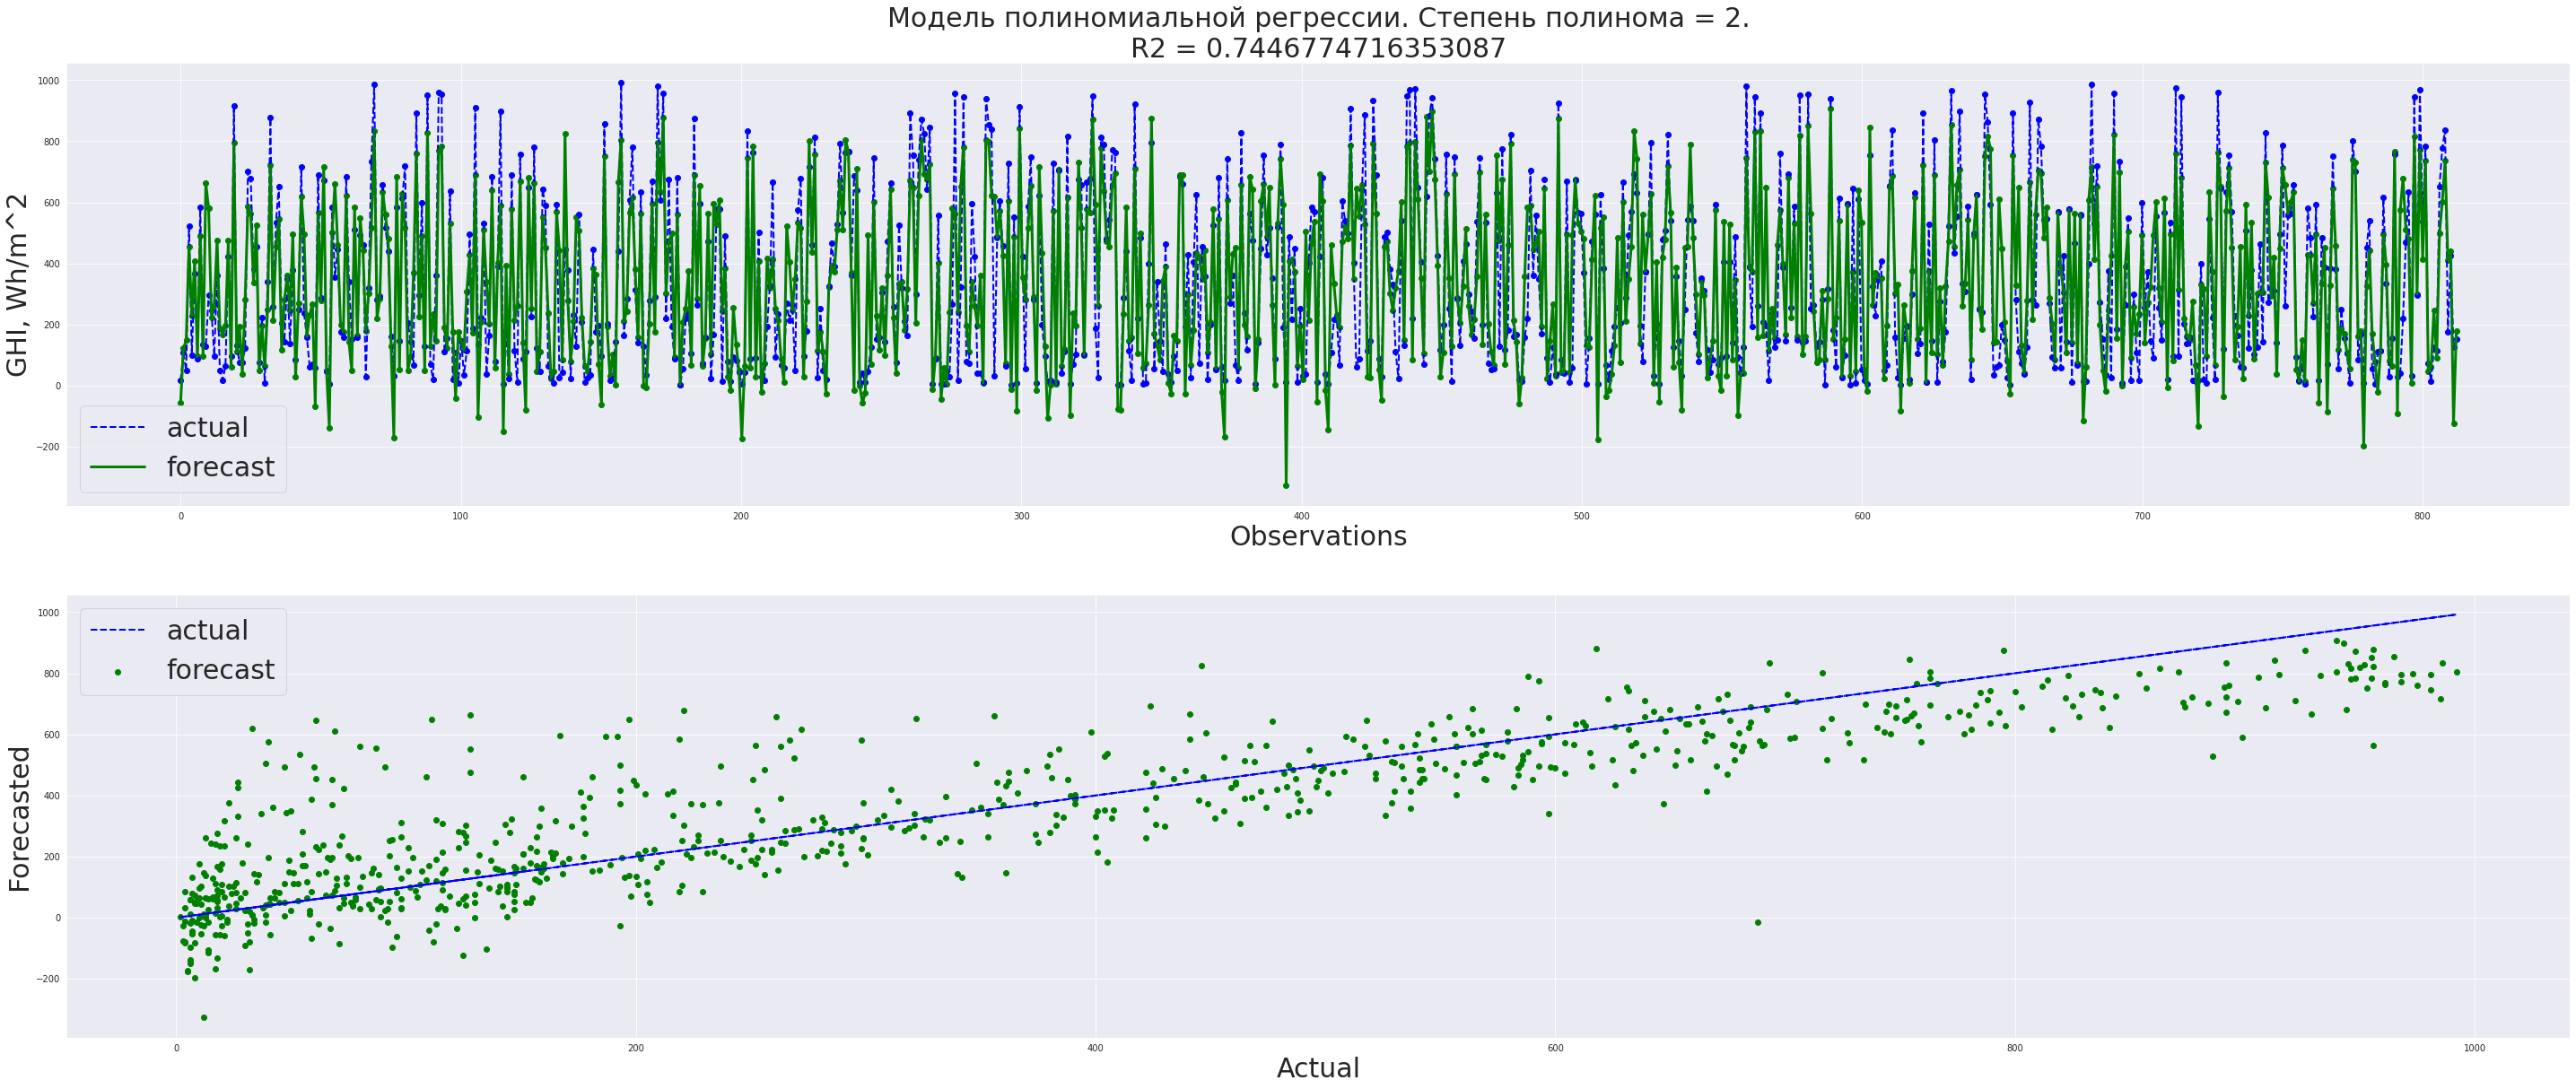

In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0])
plt.figure(figsize=(50,20))
plt.subplot(2,1,1)
plt.title(f'Модель полиномиальной регрессии. Степень полинома = {PF.degree}.\nR2 = {r2_score(y_test,y_pred_pipe)}', fontsize=30)
plt.scatter(x, y_pred_pipe, c='g')
plt.scatter(x, y_test, c='b')
plt.plot(x, y_test, '--b', linewidth=2, label='actual')
plt.plot(x, y_pred_pipe, '-g', linewidth=3, label='forecast')
plt.legend(fontsize=30)
plt.xlabel('Observations', fontsize=30)
plt.ylabel('GHI, Wh/m^2', fontsize=30)
plt.grid()
plt.subplot(2,1,2)
plt.plot(y_test, y_test, '--b', linewidth=2, label='actual')
plt.scatter(y_test, y_pred_pipe, label='forecast', c='g')
plt.legend(fontsize=30)
plt.xlabel('Actual', fontsize=30)
plt.ylabel('Forecasted', fontsize=30)
plt.grid()

## Модель ближайших соседей (KNN)

In [ ]:
k_reg = KNeighborsRegressor(n_neighbors=7, weights='distance')
k_reg.fit(X_train, y_train)
scoring_k  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores_k = cross_validate(k_reg, X_train, y_train, scoring = scoring_k, cv=ShuffleSplit(n_splits=5))
y_pred_k = k_reg.predict(X_test)
print('Cross-Validation error')
DF_reg_k = pd.DataFrame(scores_k)
display(DF_reg_k)

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_k))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_k))

Cross-Validation error


fit_time  score_time   test_R2     test_-MSE   test_-MAE    test_Max
0  0.012971    0.010533  0.363677 -54574.911246 -194.289724 -729.179200
1  0.009447    0.015413  0.296595 -51935.782542 -177.045231 -711.996214
2  0.030933    0.020516  0.271996 -59102.811056 -192.788672 -798.433946
3  0.013898    0.031836  0.404484 -52307.743593 -187.208713 -622.190293
4  0.007924    0.010404  0.320464 -63238.689430 -197.577652 -747.722175

Mean squared error on test_set: 59137.7083
R2  on test_set: 0.2828


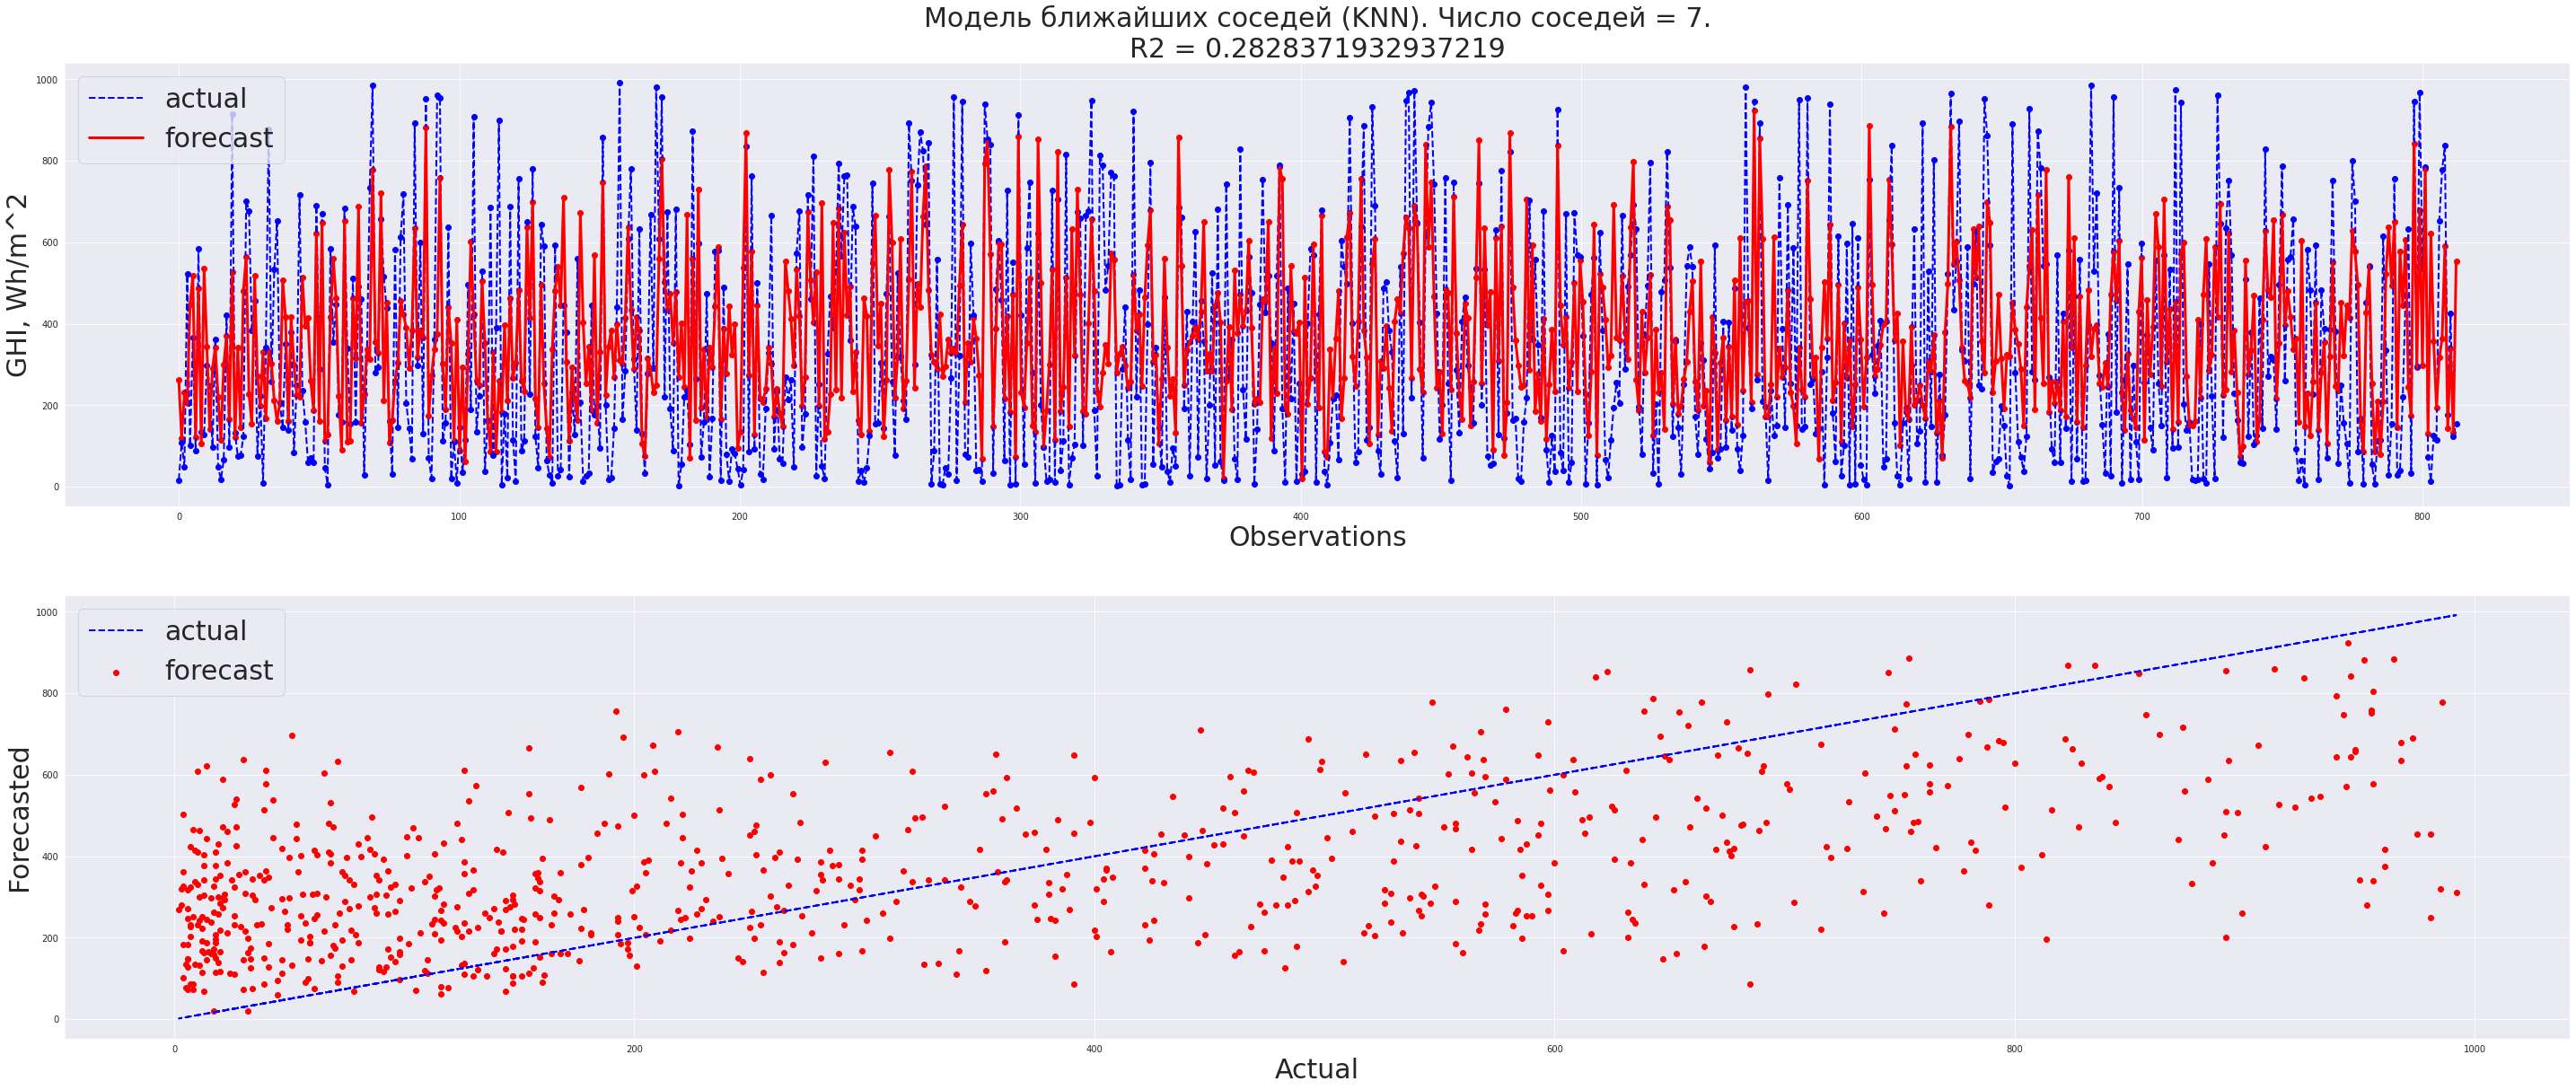

In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0])
plt.figure(figsize=(50,20))
plt.subplot(2,1,1)
plt.title(f'Модель ближайших соседей (KNN). Число соседей = {k_reg.n_neighbors}.\nR2 = {r2_score(y_test,y_pred_k)}', fontsize=30)
plt.scatter(x, y_pred_k, c='r')
plt.scatter(x, y_test, c='b')
plt.plot(x, y_test, '--b', linewidth=2, label='actual')
plt.plot(x, y_pred_k, '-r', linewidth=3, label='forecast')
plt.legend(fontsize=30)
plt.xlabel('Observations', fontsize=30)
plt.ylabel('GHI, Wh/m^2', fontsize=30)
plt.grid()
plt.subplot(2,1,2)
plt.plot(y_test, y_test, '--b', linewidth=2, label='actual')
plt.scatter(y_test, y_pred_k, label='forecast', c='r')
plt.legend(fontsize=30)
plt.xlabel('Actual', fontsize=30)
plt.ylabel('Forecasted', fontsize=30)
plt.grid()

## Обычные деревья решений

In [ ]:
DT = DecisionTreeRegressor(max_depth=8)
DT.fit(X_train, y_train)
scoring_DT  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores_DT = cross_validate(DT, X_train, y_train, scoring = scoring_DT, cv=ShuffleSplit(n_splits=5))
y_pred_DT = DT.predict(X_test)
print('Cross-Validation error')
DF_reg_DT = pd.DataFrame(scores_DT)
display(DF_reg_DT)

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_DT))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_DT))

Cross-Validation error


fit_time  score_time   test_R2     test_-MSE   test_-MAE    test_Max
0  0.011531    0.006025  0.719242 -23704.644431 -109.527626 -557.166667
1  0.010844    0.005355  0.749731 -21733.250767 -104.326723 -516.100000
2  0.011645    0.005852  0.745068 -21346.204613  -96.983179 -786.333333
3  0.011488    0.004603  0.662645 -28537.143385 -114.560540 -607.927632
4  0.010732    0.004509  0.795112 -17286.166661  -88.644612 -522.952381

Mean squared error on test_set: 21178.6412
R2  on test_set: 0.7432


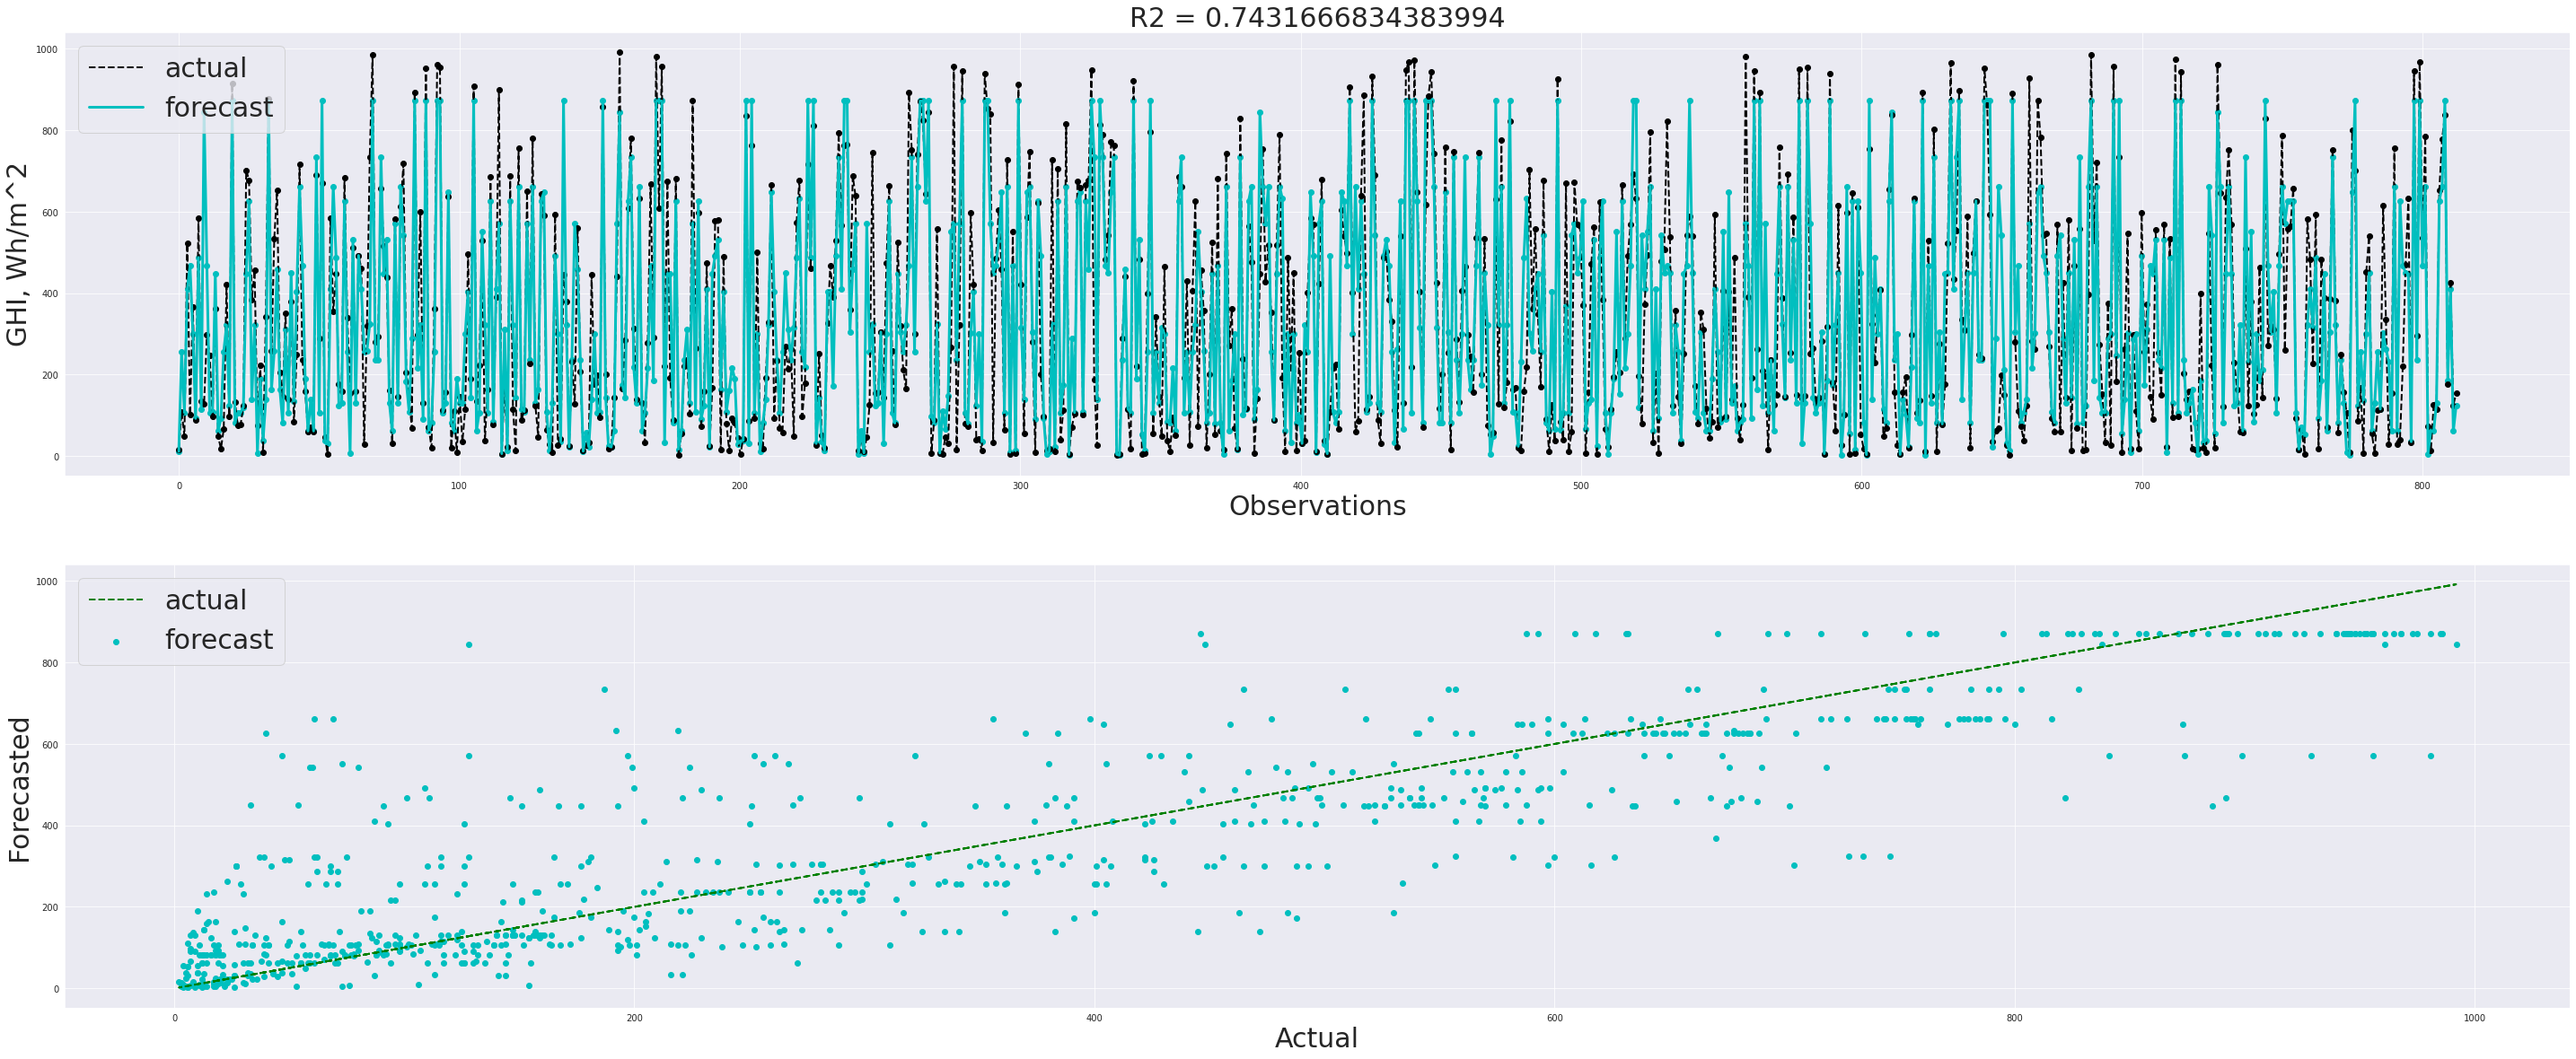

In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0])
plt.figure(figsize=(50,20))
plt.subplot(2,1,1)
plt.title(f'R2 = {r2_score(y_test,y_pred_DT)}', fontsize=30)
plt.scatter(x, y_pred_DT, c='c')
plt.scatter(x, y_test, c='k')
plt.plot(x, y_test, '--k', linewidth=2, label='actual')
plt.plot(x, y_pred_DT, '-c', linewidth=3, label='forecast')
plt.legend(fontsize=30)
plt.xlabel('Observations', fontsize=30)
plt.ylabel('GHI, Wh/m^2', fontsize=30)
plt.grid()
plt.subplot(2,1,2)
plt.plot(y_test, y_test, '--g', linewidth=2, label='actual')
plt.scatter(y_test, y_pred_DT, label='forecast', c='c')
plt.legend(fontsize=30)
plt.xlabel('Actual', fontsize=30)
plt.ylabel('Forecasted', fontsize=30)
plt.grid()

## Ансамблевые модели

## Случайный лес

In [ ]:
RF = RandomForestRegressor(n_estimators=200, max_depth=8, max_features=5, criterion = 'squared_error')
RF.fit(X_train, y_train)
scoring_RF  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores_RF = cross_validate(RF, X_train, y_train, scoring = scoring_RF, cv=ShuffleSplit(n_splits=5))
y_pred_RF = RF.predict(X_test)
print('Cross-Validation error')
DF_reg_RF = pd.DataFrame(scores_RF)
display(DF_reg_RF)

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_RF))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_RF))

Cross-Validation error


fit_time  score_time   test_R2     test_-MSE   test_-MAE    test_Max
0  0.675548    0.033697  0.722990 -24119.883785 -108.248358 -592.688575
1  0.706035    0.030563  0.805493 -16382.825316  -92.029161 -435.270562
2  0.686525    0.032305  0.719119 -23074.247310 -110.988493 -605.129475
3  0.679748    0.030410  0.758319 -19741.031402 -104.392782 -551.142691
4  0.714193    0.033185  0.739537 -19570.455336 -103.617902 -480.801134

Mean squared error on test_set: 20060.4784
R2  on test_set: 0.7567


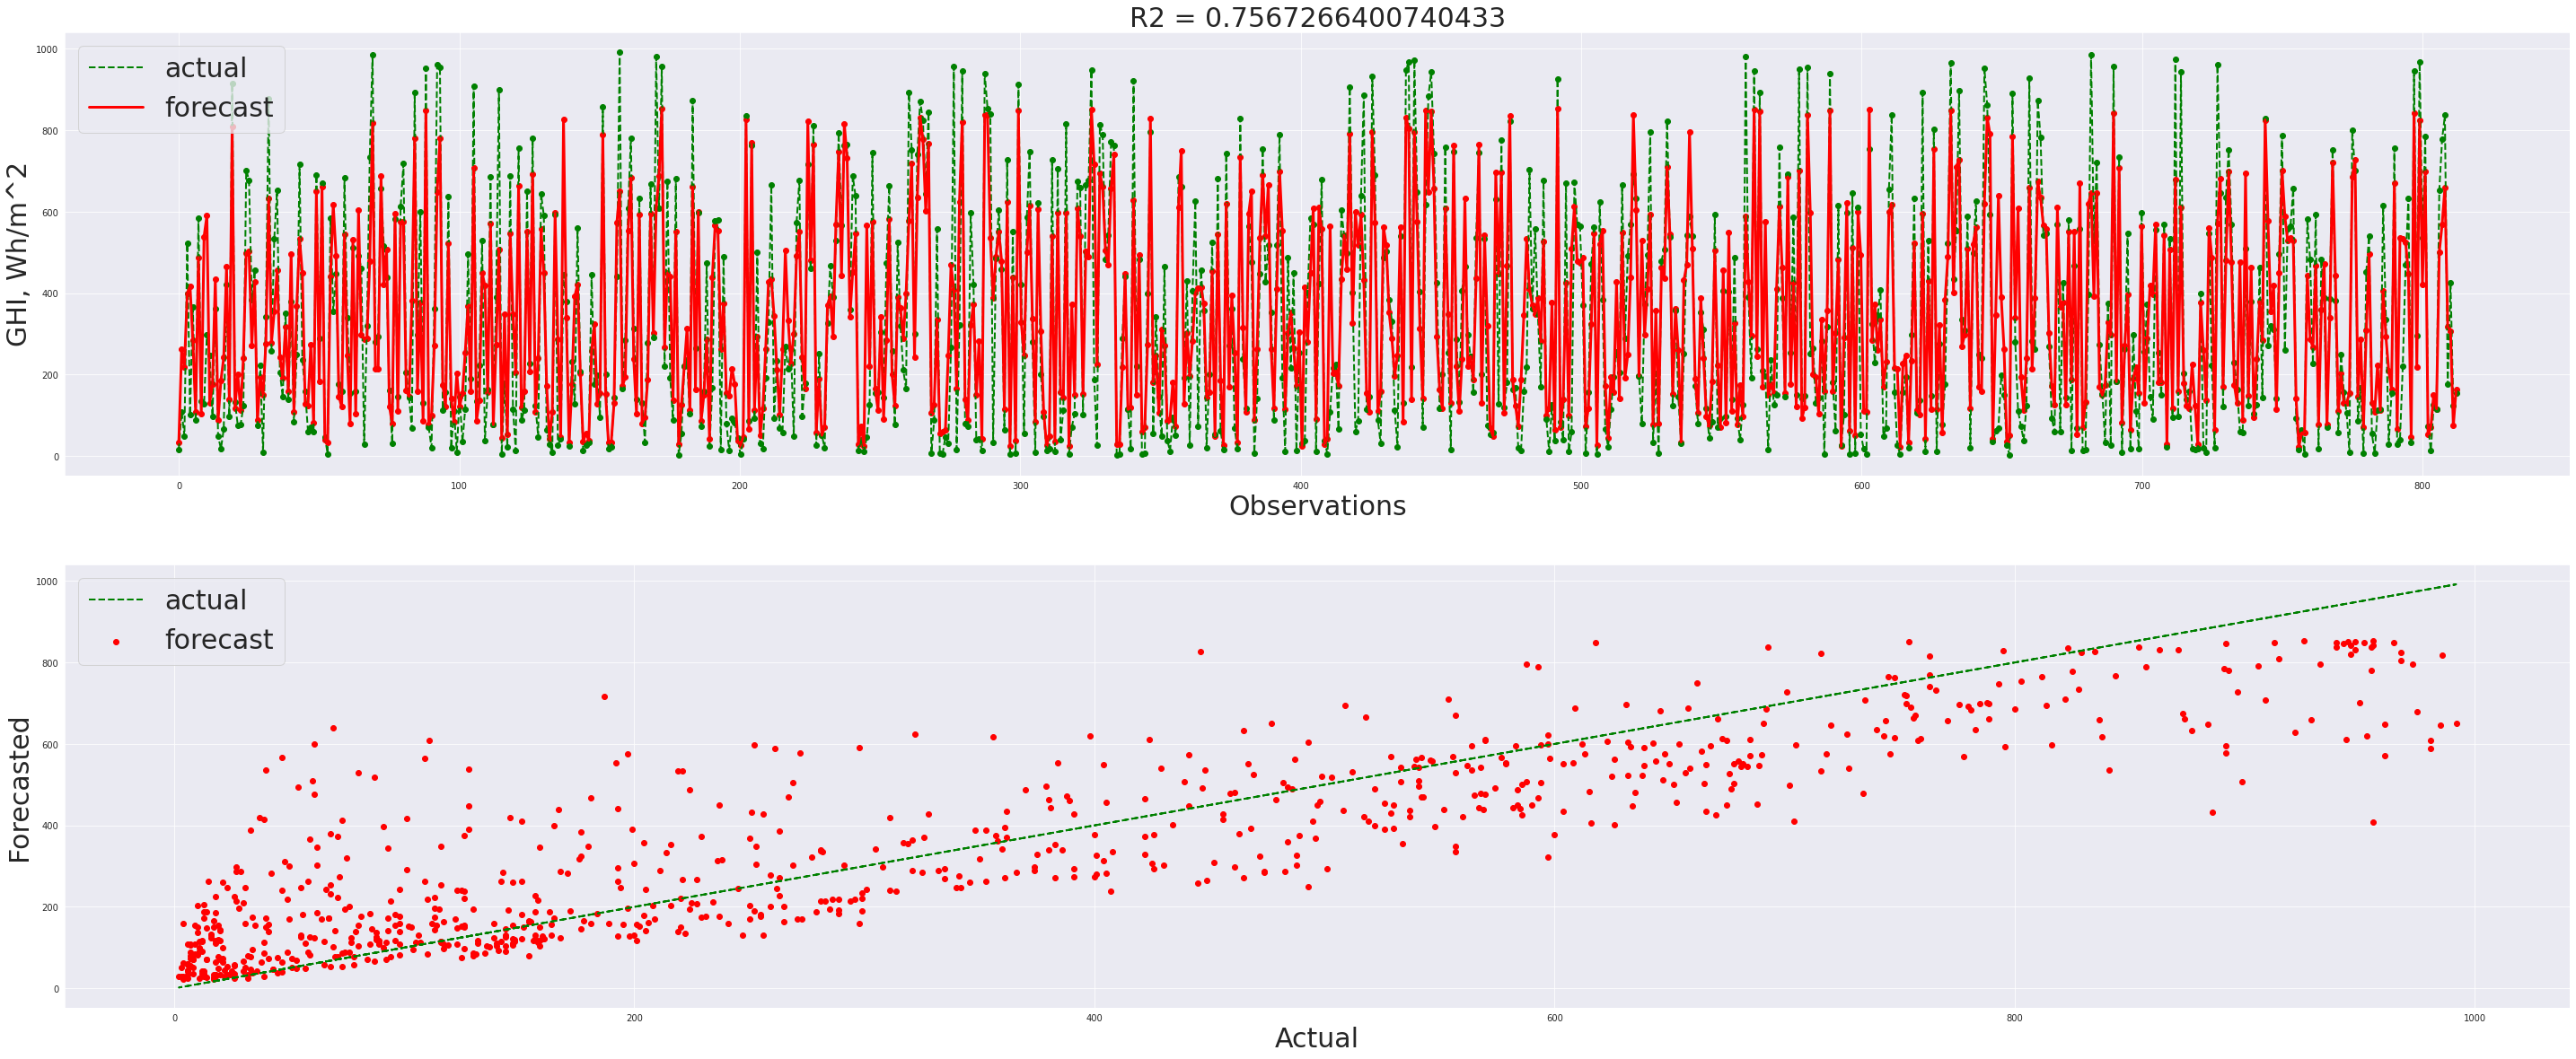

In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0])
plt.figure(figsize=(50,20))
plt.subplot(2,1,1)
plt.title(f'R2 = {r2_score(y_test,y_pred_RF)}', fontsize=30)
plt.scatter(x, y_pred_RF, c='r')
plt.scatter(x, y_test, c='g')
plt.plot(x, y_test, '--g', linewidth=2, label='actual')
plt.plot(x, y_pred_RF, '-r', linewidth=3, label='forecast')
plt.legend(fontsize=30)
plt.xlabel('Observations', fontsize=30)
plt.ylabel('GHI, Wh/m^2', fontsize=30)
plt.grid()
plt.subplot(2,1,2)
plt.plot(y_test, y_test, '--g', linewidth=2, label='actual')
plt.scatter(y_test, y_pred_RF, label='forecast', c='r')
plt.legend(fontsize=30)
plt.xlabel('Actual', fontsize=30)
plt.ylabel('Forecasted', fontsize=30)
plt.grid()

## Градиентный бустинг

In [ ]:
GB = GradientBoostingRegressor(n_estimators=350, max_depth=8, learning_rate=0.01,)
GB.fit(X_train, y_train)
scoring_GB  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores_GB = cross_validate(GB, X_train, y_train, scoring = scoring_GB, cv=ShuffleSplit(n_splits=5))
y_pred_GB = GB.predict(X_test)
print('Cross-Vlidation error')
DF_reg_GB = pd.DataFrame(scores_GB)
display(DF_reg_GB)

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_GB))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_GB))

Cross-Vlidation error


fit_time  score_time   test_R2     test_-MSE   test_-MAE    test_Max
0  2.083524    0.011621  0.722788 -21636.353727  -99.506611 -735.252725
1  2.040620    0.010055  0.769720 -17940.196271  -93.615082 -478.181339
2  2.075899    0.010335  0.805600 -15386.402154  -87.140272 -535.708708
3  2.010257    0.011729  0.747250 -19464.491366 -100.387771 -597.228455
4  1.999878    0.011270  0.754521 -20508.701386  -91.922329 -765.041681

Mean squared error on test_set: 17421.5346
R2  on test_set: 0.7887


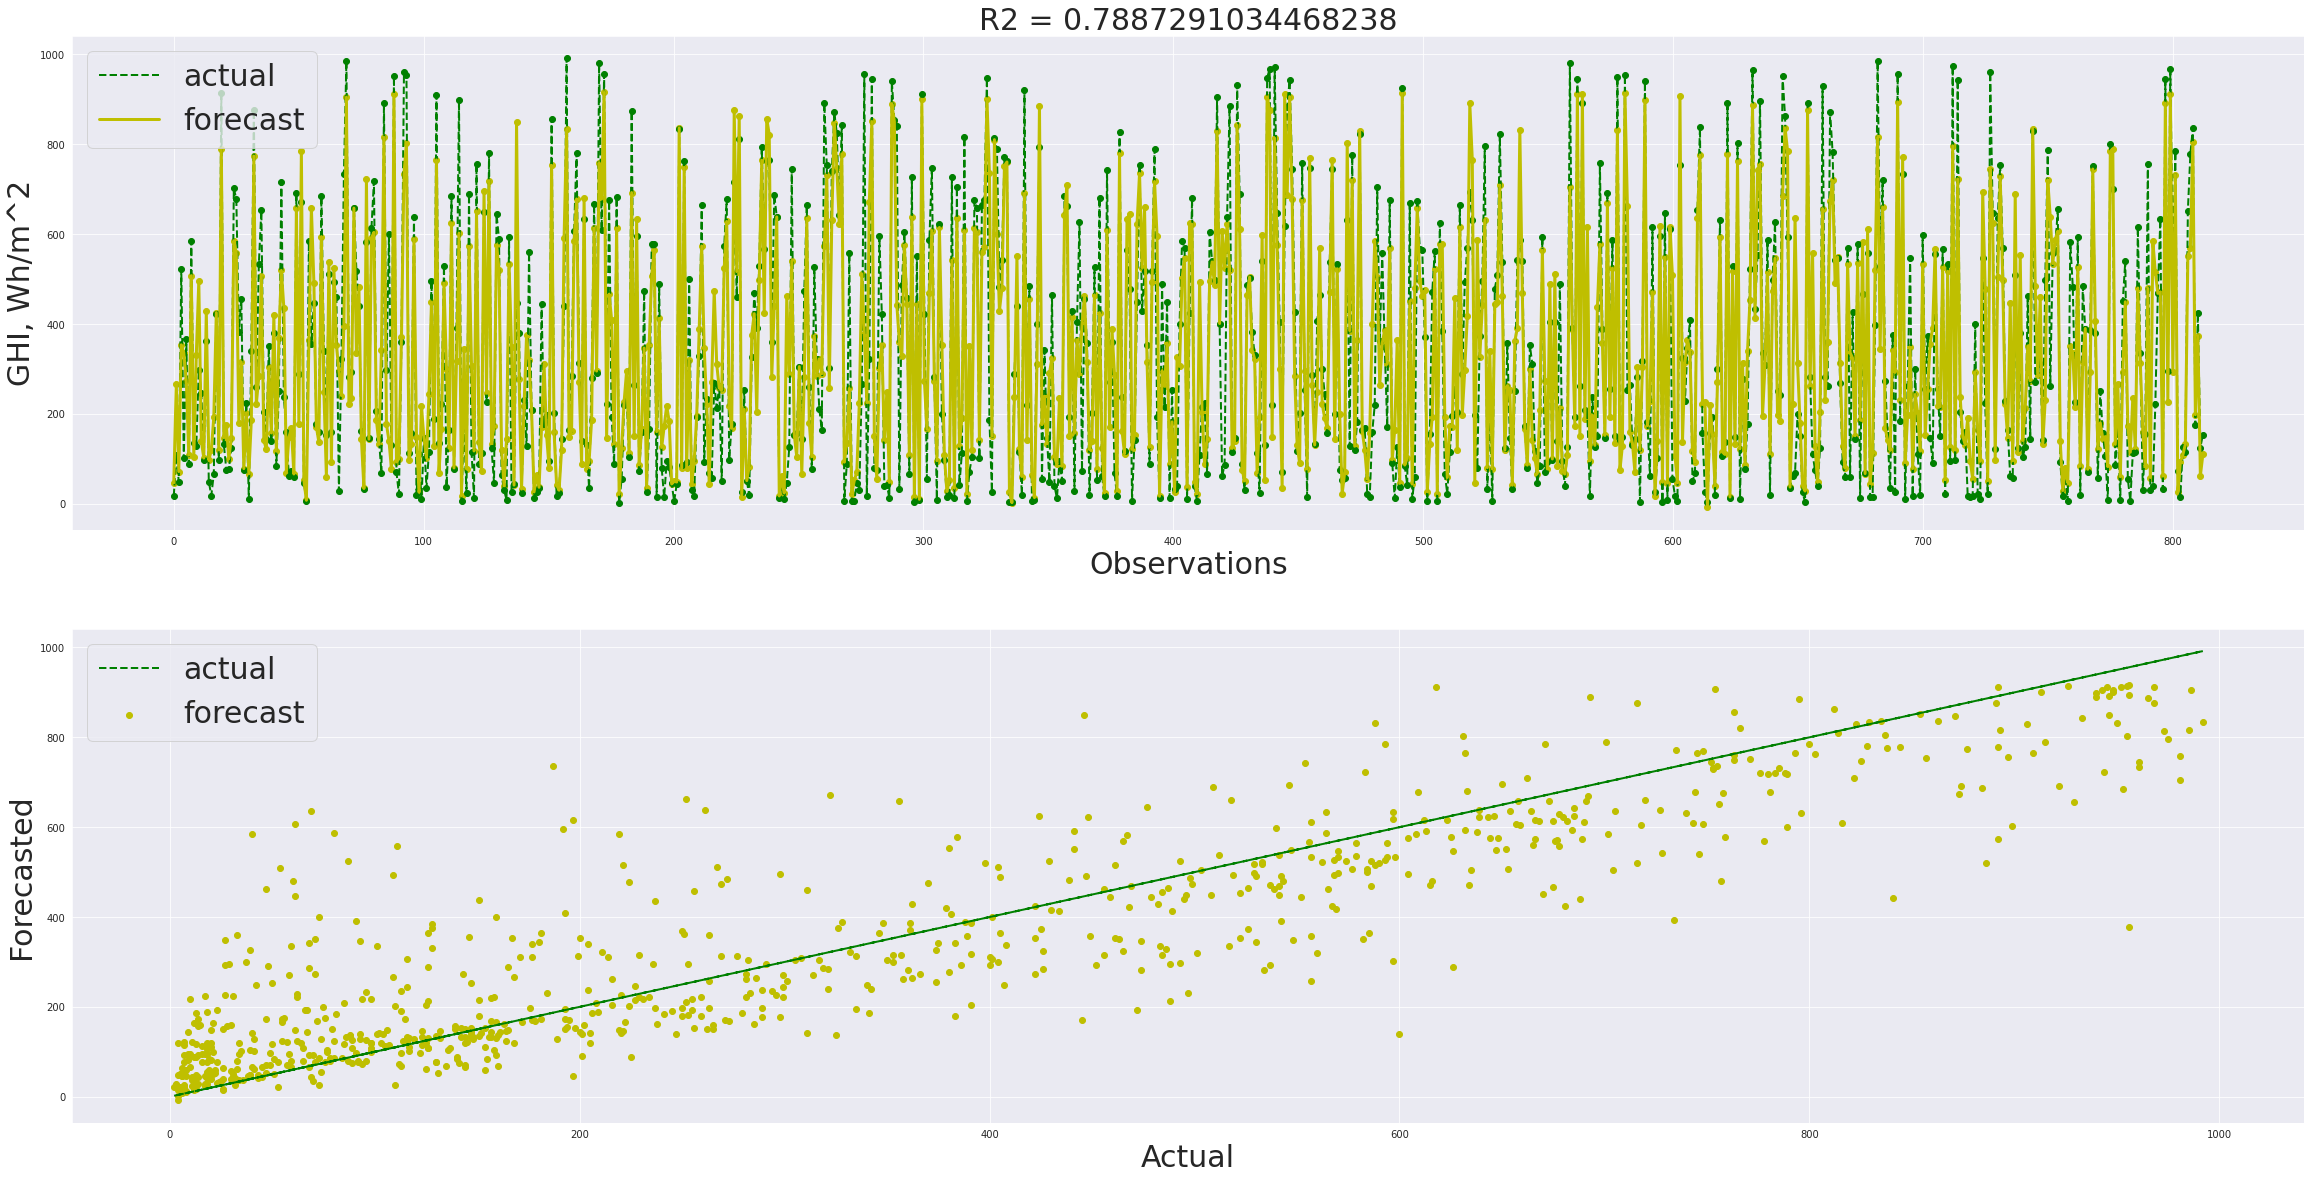

In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0])
plt.figure(figsize=(40,20))
plt.subplot(2,1,1)
plt.title(f'R2 = {r2_score(y_test,y_pred_GB)}', fontsize=30)
plt.scatter(x, y_pred_GB, c='y')
plt.scatter(x, y_test, c='g')
plt.plot(x, y_test, '--g', linewidth=2, label='actual')
plt.plot(x, y_pred_GB, '-y', linewidth=3, label='forecast')
plt.legend(fontsize=30)
plt.xlabel('Observations', fontsize=30)
plt.ylabel('GHI, Wh/m^2', fontsize=30)
plt.grid()
plt.subplot(2,1,2)
plt.plot(y_test, y_test, '--g', linewidth=2, label='actual')
plt.scatter(y_test, y_pred_GB, label='forecast', c='y')
plt.legend(fontsize=30)
plt.xlabel('Actual', fontsize=30)
plt.ylabel('Forecasted', fontsize=30)
plt.grid()

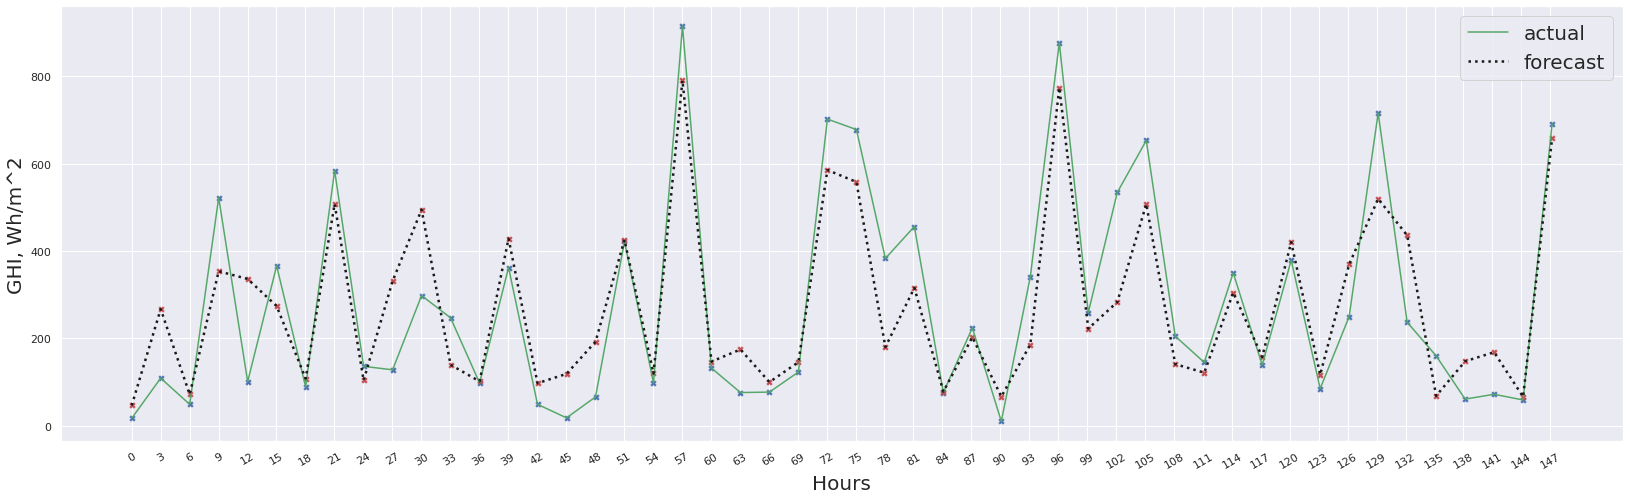

In [ ]:
plt.figure(figsize=(28,8))
sn.set_theme()
plt.scatter(x[:50], y_test[:50], c='b', marker = 'X', linewidth=0.14)
plt.plot(x[:50], y_test[:50], '-g', linewidth=1.5, label='actual')

plt.scatter(x[:50], y_pred_GB[:50], c='r',  marker = 'X', linewidth = 0.14)
plt.plot(x[:50], y_pred_GB[:50], ':k', linewidth=2.5, label='forecast')

plt.legend(fontsize=20)

plt.xlabel('Hours', fontsize=20)
plt.xticks(np.arange(0, 50, step=1), np.arange(0, 150, 3), rotation = 30)
plt.ylabel('GHI, Wh/m^2', fontsize=20);


## Стэкинг

In [ ]:
estimators = [('lr', lin_reg)]
stack_reg = StackingRegressor(estimators = estimators, final_estimator = GradientBoostingRegressor(), n_jobs=-1, passthrough = True)
stack_reg.fit(X_train, y_train)
scoring_stack  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores_stack = cross_validate(stack_reg, X_train, y_train, scoring = scoring_stack, cv=ShuffleSplit(n_splits=5))
y_pred_stack = stack_reg.predict(X_test)

print('Cross-Validation error')
DF_reg_stack = pd.DataFrame(scores_stack)
display(DF_reg_stack)

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_stack))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_stack))
print('MAE  on test_set: %.4f' %  mae(y_test,y_pred_stack))
print('nMAE  on test_set: %.4f' %  (mae(y_test,y_pred_stack)/np.mean(y_test)))
print('ME  on test_set: %.4f' %  max_error(y_test,y_pred_stack))

Cross-Validation error


fit_time  score_time   test_R2     test_-MSE   test_-MAE    test_Max
0  0.432092    0.005391  0.769111 -22236.337952 -103.927366 -648.445883
1  0.442705    0.005084  0.785207 -17316.763431  -92.831030 -563.108256
2  0.435688    0.006255  0.783288 -19354.802164  -95.561337 -642.683702
3  0.442569    0.005901  0.744542 -22440.060622 -105.762681 -535.888397
4  0.415625    0.004831  0.841205 -13456.574896  -88.514034 -357.185385

Mean squared error on test_set: 18588.6594
R2  on test_set: 0.7746
MAE  on test_set: 96.2123
nMAE  on test_set: 0.2865
ME  on test_set: 622.9709


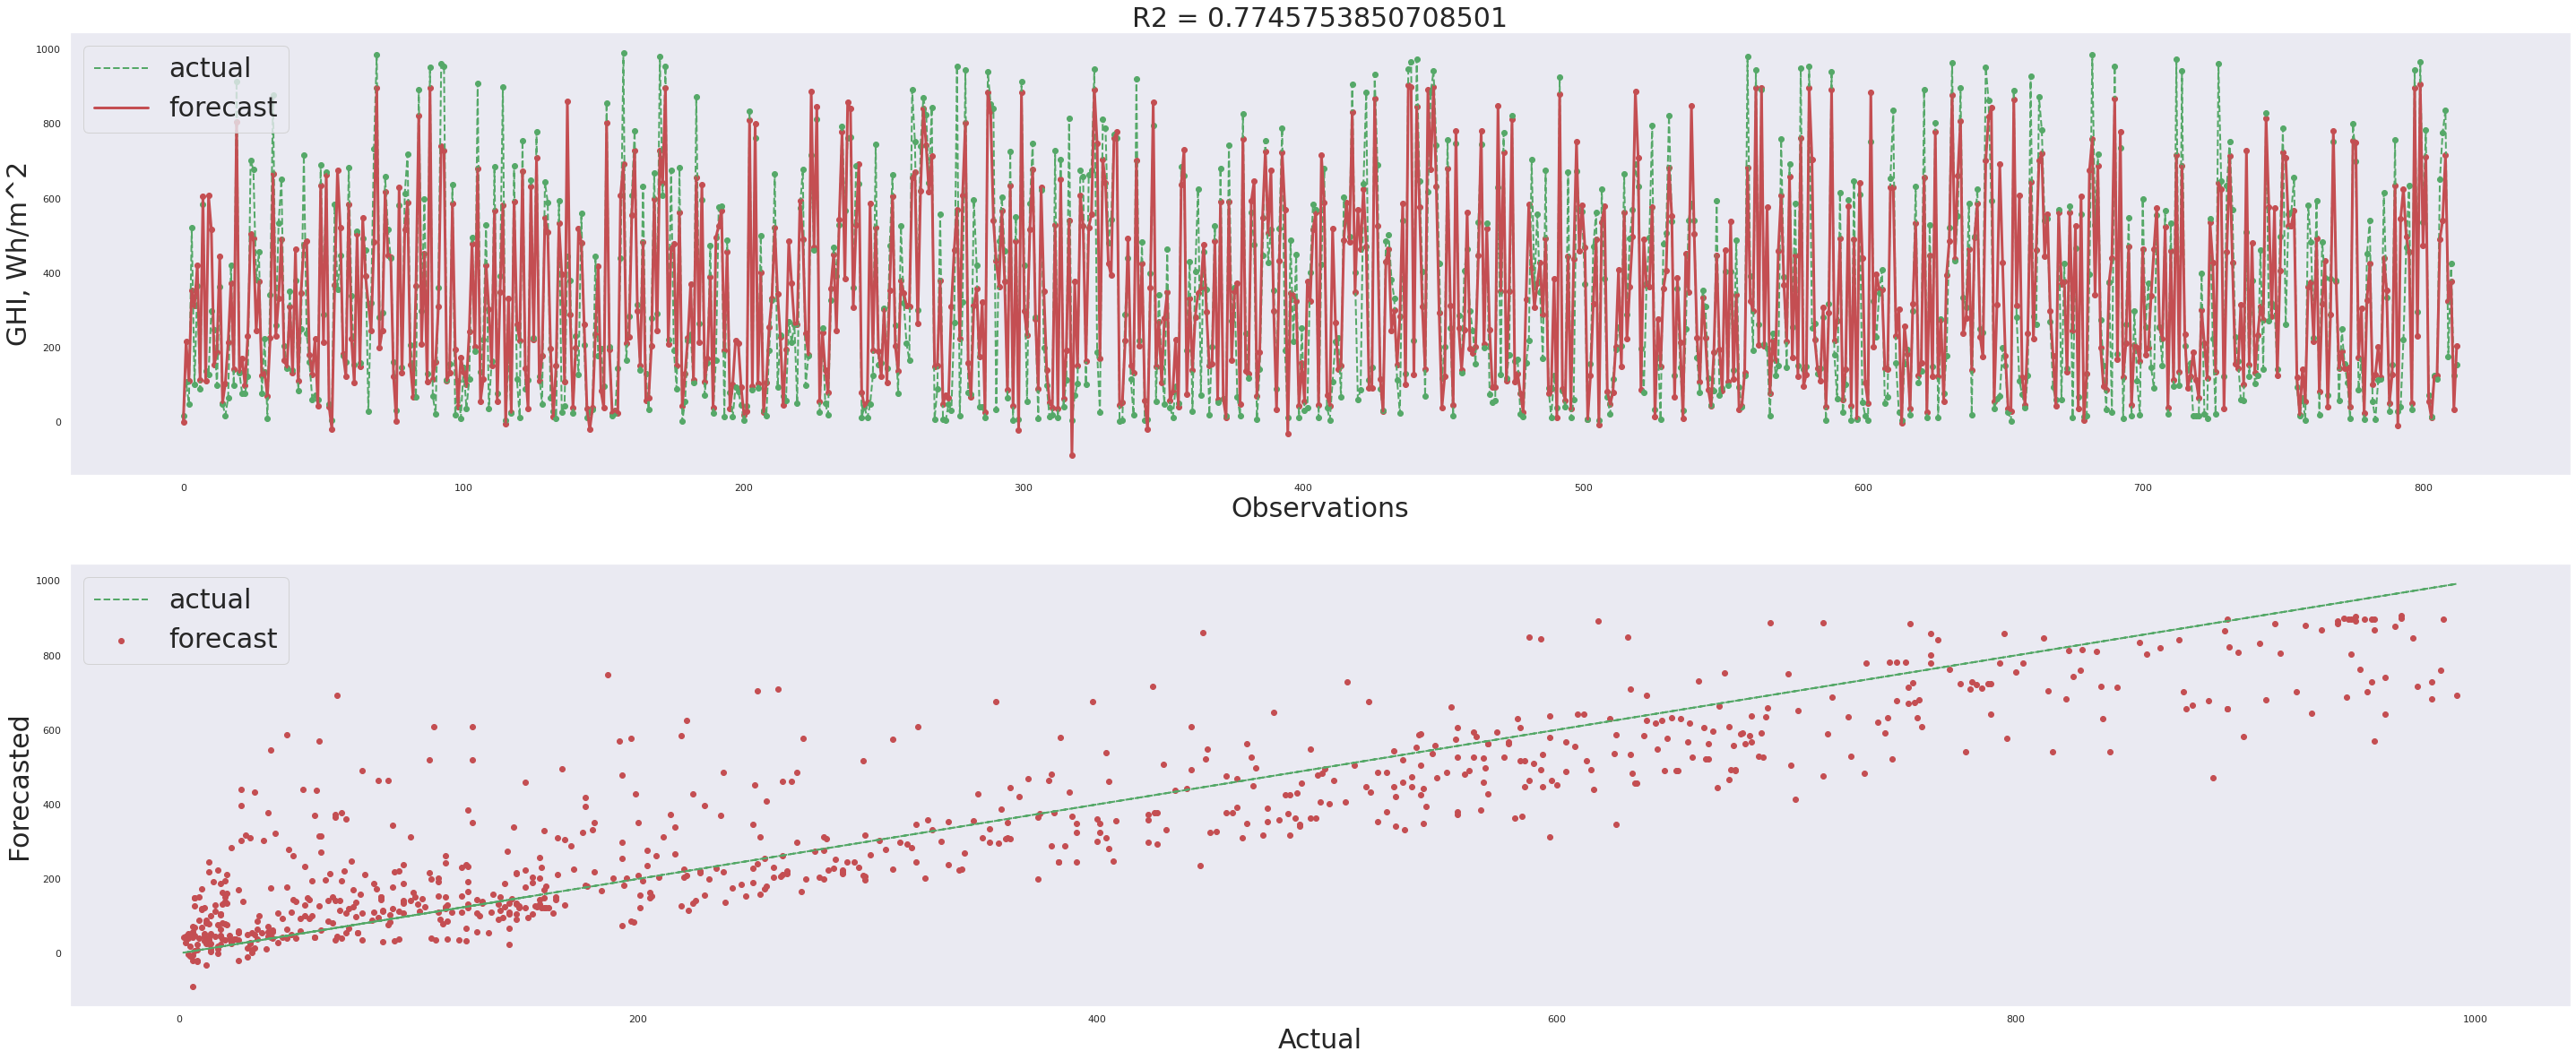

In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0])
plt.figure(figsize=(50,20))
plt.subplot(2,1,1)
plt.title(f'R2 = {r2_score(y_test,y_pred_stack)}', fontsize=30)
plt.scatter(x, y_pred_stack, c='r')
plt.scatter(x, y_test, c='g')
plt.plot(x, y_test, '--g', linewidth=2, label='actual')
plt.plot(x, y_pred_stack, '-r', linewidth=3, label='forecast')
plt.legend(fontsize=30)
plt.xlabel('Observations', fontsize=30)
plt.ylabel('GHI, Wh/m^2', fontsize=30)
plt.grid()
plt.subplot(2,1,2)
plt.plot(y_test, y_test, '--g', linewidth=2, label='actual')
plt.scatter(y_test, y_pred_stack, label='forecast', c='r')
plt.legend(fontsize=30)
plt.xlabel('Actual', fontsize=30)
plt.ylabel('Forecasted', fontsize=30)
plt.grid()

In [ ]:
estimators = [('KNN', k_reg)]
stack_reg = StackingRegressor(estimators = estimators, final_estimator = RandomForestRegressor(), n_jobs=-1, passthrough = True)
stack_reg.fit(X_train, y_train)
scoring_stack  = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}
scores_stack = cross_validate(stack_reg, X_train, y_train, scoring = scoring_stack, cv=ShuffleSplit(n_splits=5))
y_pred_stack = stack_reg.predict(X_test)

print('Cross-Validation error')
DF_reg_stack = pd.DataFrame(scores_stack)
display(DF_reg_stack)

print('Mean squared error on test_set: %.4f' % mse(y_test,y_pred_stack))
print('R2  on test_set: %.4f' %  r2_score(y_test,y_pred_stack))
print('MAE  on test_set: %.4f' %  mae(y_test,y_pred_stack))
print('nMAE  on test_set: %.4f' %  (mae(y_test,y_pred_stack)/np.mean(y_test)))
print('ME  on test_set: %.4f' %  max_error(y_test,y_pred_stack))

Cross-Validation error


fit_time  score_time   test_R2     test_-MSE   test_-MAE  test_Max
0  1.134996    0.025161  0.751956 -19600.976755  -98.717254   -514.97
1  1.050223    0.025286  0.790185 -18045.589659  -95.709754   -525.75
2  1.086180    0.033662  0.797943 -16692.256247  -89.355041   -505.16
3  1.079708    0.029524  0.722012 -24677.016166 -105.952787   -610.02
4  1.090757    0.027053  0.773102 -18975.716900  -91.832172   -596.34

Mean squared error on test_set: 18478.5084
R2  on test_set: 0.7759
MAE  on test_set: 94.7071
nMAE  on test_set: 0.2820
ME  on test_set: 666.6000


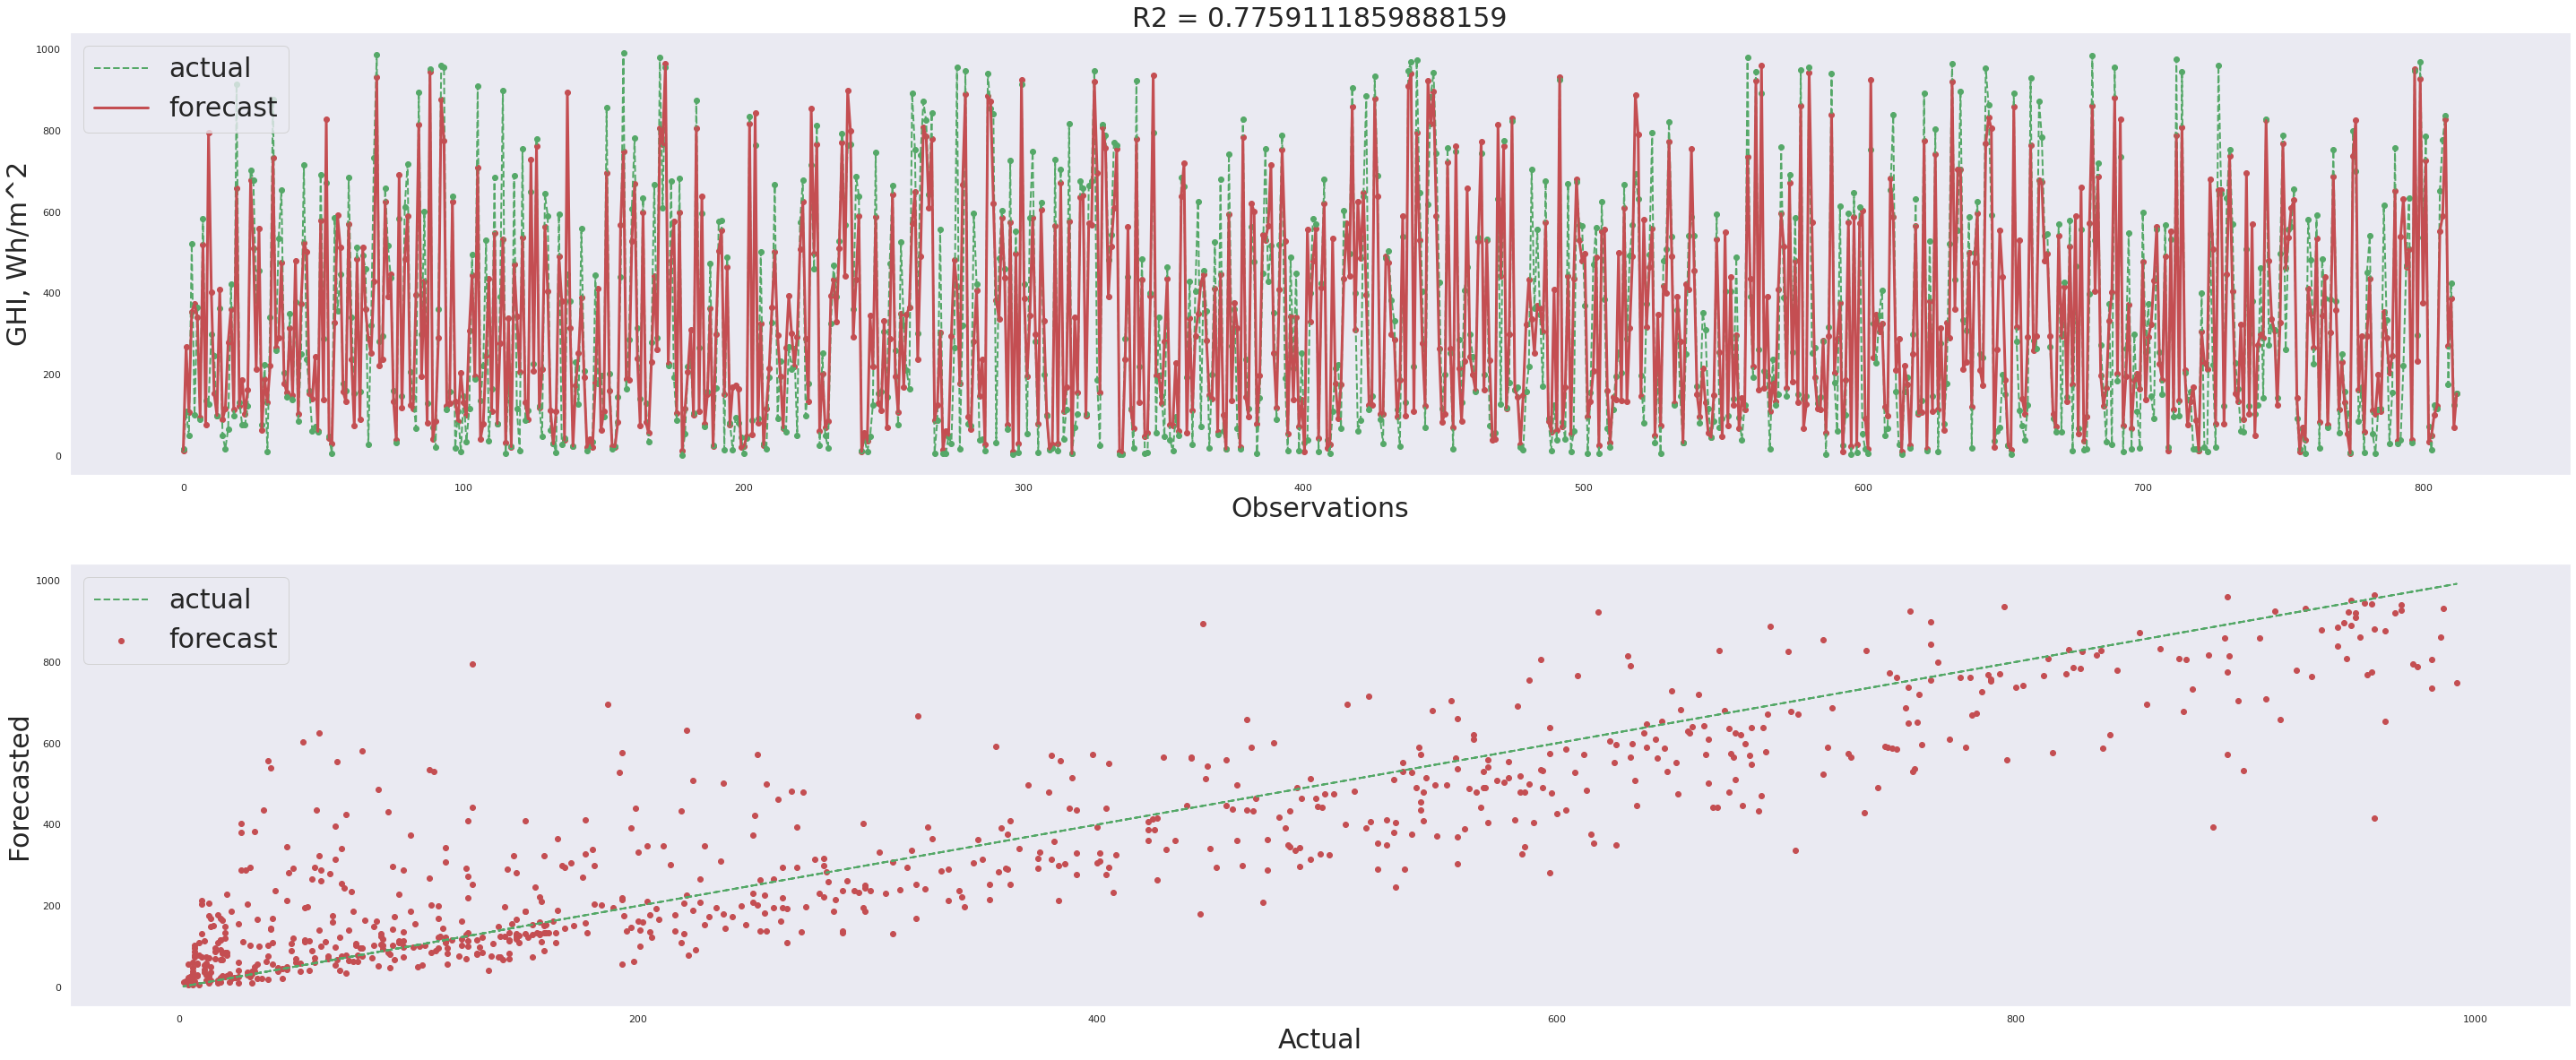

In [ ]:
x = np.linspace(0, X_test.shape[0], X_test.shape[0])
plt.figure(figsize=(50,20))
plt.subplot(2,1,1)
plt.title(f'R2 = {r2_score(y_test,y_pred_stack)}', fontsize=30)
plt.scatter(x, y_pred_stack, c='r')
plt.scatter(x, y_test, c='g')
plt.plot(x, y_test, '--g', linewidth=2, label='actual')
plt.plot(x, y_pred_stack, '-r', linewidth=3, label='forecast')
plt.legend(fontsize=30)
plt.xlabel('Observations', fontsize=30)
plt.ylabel('GHI, Wh/m^2', fontsize=30)
plt.grid()
plt.subplot(2,1,2)
plt.plot(y_test, y_test, '--g', linewidth=2, label='actual')
plt.scatter(y_test, y_pred_stack, label='forecast', c='r')
plt.legend(fontsize=30)
plt.xlabel('Actual', fontsize=30)
plt.ylabel('Forecasted', fontsize=30)
plt.grid()